In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import time

In [2]:
file_train_text = "../../data/training_text/training_text"
file_train_variant = "../../data/training_variants/training_variants"

In [3]:
train_text = pd.read_csv(file_train_text, sep = '\|\|')
train_text.index.name = "ID"
train_text.columns = ["Text"]

train_variant = pd.read_csv(file_train_variant)
train_variant.set_index("ID",inplace = True)

/home/ragou/.local/lib/python3.8/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [4]:
train_variant[train_variant["Variation"].isin(["C396R", "H398Q", "Y371H", "K382E", "C381A"])]

,Gene,Variation,Class
ID,,,
8,CBL,Y371H,4
11,CBL,K382E,4
13,CBL,C381A,4
21,CBL,C396R,4


In [8]:
train_variant[train_variant["Variation"] == "Q249E"]

,Gene,Variation,Class
ID,,,
2,CBL,Q249E,2


In [5]:
train_text.loc[[6],]

,Text
ID,
6,Oncogenic mutations in the monomeric Casitas B...


In [10]:
gene_count = train_variant["Gene"].value_counts().loc[lambda x : x > 100].to_dict()

In [11]:
gene_class = train_variant[train_variant["Gene"].isin(gene_count.keys())]

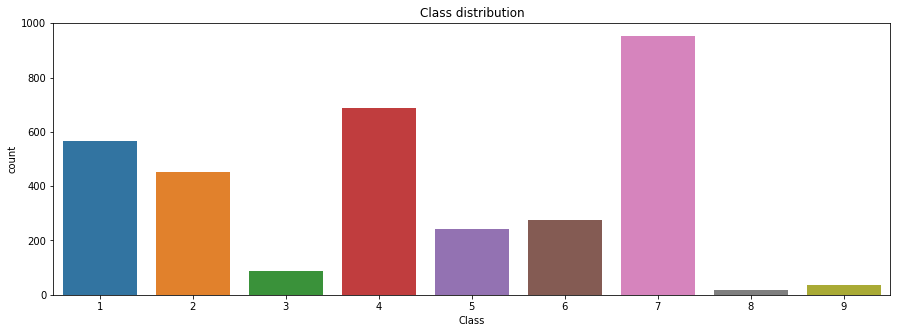

In [12]:
plt.figure(figsize=(15,5))
sns.countplot(x = train_variant["Class"])
plt.title("Class distribution")
plt.show()

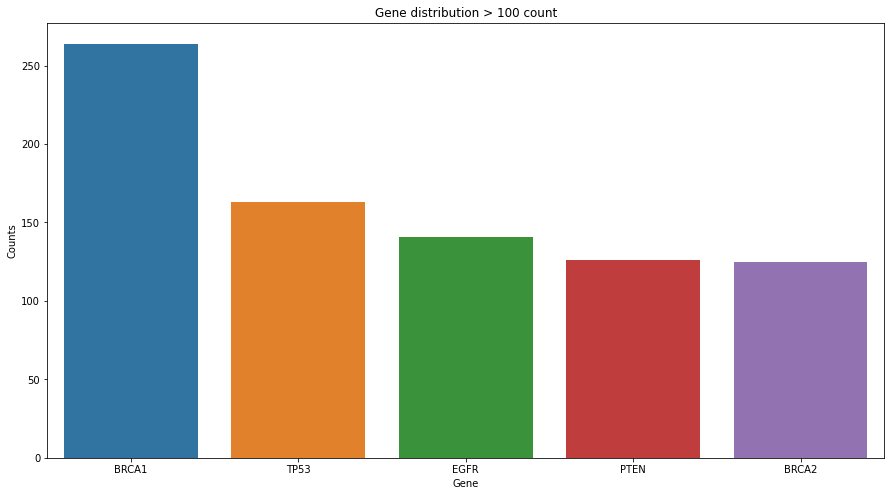

In [13]:
plt.figure(figsize=(15,8))

sns.barplot( x = list(gene_count.keys()), y = list(gene_count.values()))
plt.title("Gene distribution > 100 count")
plt.ylabel("Counts")
plt.xlabel("Gene")

plt.show()

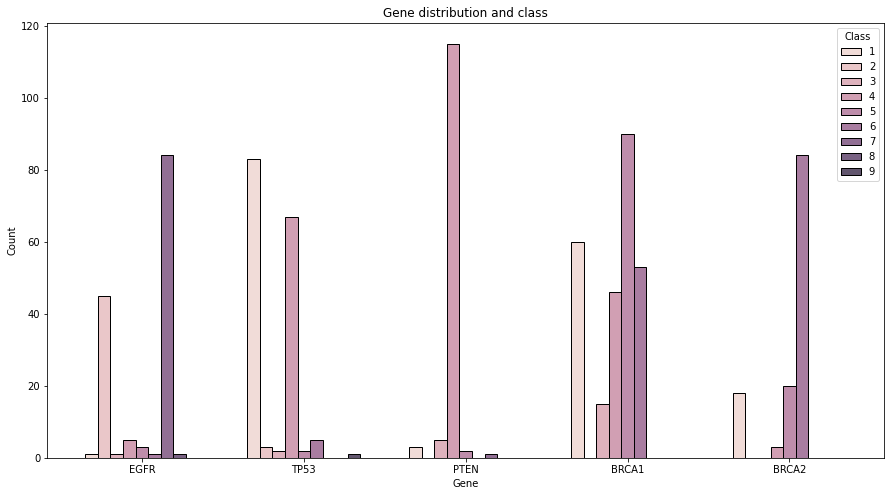

In [11]:
plt.figure(figsize=(15,8))
sns.histplot(data=train_variant[train_variant["Gene"].isin(gene_count.keys())],
             x="Gene", hue="Class", multiple="dodge", shrink=.7)
plt.title("Gene distribution and class")
plt.show()

In [12]:
train_variant.head(5)

,Gene,Variation,Class
ID,,,
0,FAM58A,Truncating Mutations,1
1,CBL,W802*,2
2,CBL,Q249E,2
3,CBL,N454D,3
4,CBL,L399V,4


In [13]:
train_variant[train_variant["Gene"] == "RAD51"]

,Gene,Variation,Class
ID,,,


In [6]:
amino_acid_dict = {'C' : 'CYS', 'D' : 'ASP', 'S' : 'SER', 'Q' : 'GLN', 'K' : 'LYS',
    'I' : 'ILE', 'P' : 'PRO', 'T' : 'THR', 'F' : 'PHE', 'N' : 'ASN', 
    'G' : 'GLY', 'H' : 'HIS', 'L' : 'LEU', 'R' : 'ARG', 'W' : 'TRP', 
    'A' : 'ALA', 'V' : 'VAL', 'E' : 'GLU', 'Y' : 'TYR', 'M' : 'MET'}

# Fonction pour la selection

## clean_text
Nettoie l'article, lower puis enlève les points qui pourrait nuire à la detection des phrases, (comme les "...", ou "fig.A")


## find_match
Va détecter la phrase qui contient le mot, puis prend 1 phrase avant et après (au total 3 phrase) (voir diapo)

In [7]:
def amino_three(amino):
    return amino_acid_dict[amino]
    
def decompose_variation(variation):
    decompose_aa_pos_aa = re.compile("([a-z]{1,})(\d+)([a-z]{1,})")
    list_variation = decompose_aa_pos_aa.search(variation)
    if list_variation:
        aa1 = list_variation.group(1)
        aa2 = list_variation.group(3)

        if len(aa1) + len(aa2) == 2:
            amino1 = amino_acid_dict[aa1.upper()].lower()
            position = list_variation.group(2)
            amino2 = amino_acid_dict[aa2.upper()].lower()
            return [amino1,position,amino2]
    return False

def decompose_fusion(variation):
    decompose_g1_g2_fusion = re.compile("(\w+)\s?(\?|-)\s?(\w+)\? fusion")
    list_variation = decompose_g1_g2_fusion.search(variation)
    if list_variation:
        gene1 = list_variation.group(1)
        gene2 = list_variation.group(3)
        return "(" + gene1 + "|" + gene2 + ")"
    return False
        
    
def decompose_dup(variation):
    decompose_mut_pos = re.compile("([a-z]{1,})(\d+)dup")
    list_mut = decompose_mut_pos.search(variation)
    if list_mut:
        mut = list_mut.group(1)
        pos = list_mut.group(2)
        return mut + "" + pos
    return False

In [19]:
def clean_text(article):
    dot3 = re.compile("[\.]{2,}")
    fig = re.compile("fig[s]?\.")
    decimal = re.compile("\d+\.\d+")    
    etal = re.compile("et al\.")
    ie = re.compile("i\.e\.")
    inc = re.compile("inc\.")
    mutation_point = re.compile("[p|c]\.")
    
    clean_article = article.lower()
    clean_article = dot3.sub(".", clean_article)
    clean_article = fig.sub("", clean_article)
    clean_article = decimal.sub("", clean_article)
    clean_article = etal.sub("", clean_article)
    clean_article = ie.sub("", clean_article)    
    clean_article = inc.sub("", clean_article)    
    clean_article = mutation_point.sub("", clean_article)    
    
    
    return clean_article

def join_tuple_string(strings_tuple):
    return ' '.join(strings_tuple)

def find_match(text, word):
    clean = clean_text(text)
    word = word.lower()
    target_sentence = "([^.]*{}[^.]*\.)".format(word)
    before_after_target = "([^.]*\.){0,1}"    
    match_exp = re.compile(before_after_target + target_sentence + before_after_target)
    match_text = match_exp.findall(clean)
    final_match = "".join(list(map(join_tuple_string, match_text)))
    return final_match

def extract_match(line):
    # Mettre celui qui consomme le moins en 1er --> ceux qui sont facile à faire sans trop de calcul !
    # 1er : best match
    # 2e ?
    
    
    # Cleaning text --> Already clean, no need    
    text = line["Text"]
    variation = line["Variation"]
    #gene = line["Gene"].lower()
    
    if len(text) < 10000:
        return text,7
    # Splice
    if "splice" in variation:
        match_splice = find_match(text, "splice")
        if len(match_splice) != 0:
            return match_splice, 2
        
    if "fs" in variation:
        match_fs = find_match(text, "frameshift")
        if len(match_fs) != 0:
            return match_fs, 2
        
    # Amplification
    if 'ampli' in variation:
        match_ampli = find_match(text, "(amplif|increse)")
        if len(match_ampli) != 0:
            return match_ampli,3
    
    # Duplication
    if "dup" in variation:
        decomp_dup = decompose_dup(variation)
        if decomp_dup:
            match_mut_pos = find_match(text, decomp_dup)
            if len(match_mut_pos) != 0:
                return match_mut_pos,2
        
        match_dup = find_match(text, "dup")
        if len(match_dup) != 0:
            return match_dup, 3
        
    # Try with * --> w802*
    if "*" in variation:
        new_var = variation.replace("*", "\\*")
        match_star = find_match(text, new_var)
        if len(match_star) != 0:
            return match_star, 1
        if "fs" in variation:
            match_fs = find_match(text, "fs\\*")
            if len(match_fs) != 0:
                return match_fs, 3
            
        match_stop_nonsense = find_match(text,"(stop|nonsense)")
        if len(match_stop_nonsense) != 0:
            return match_stop_nonsense, 2

    # Try first match with inital variation value
    # Quality score = 1 
    initial_match = find_match(text, variation)    
    if len(initial_match) != 0:
        #print("First match ! ", variation)
        return initial_match, 1
    
    
    # deletion and insertion
    if "del" in variation or "ins" in variation:
        match_delins = find_match(text, "(deletion|insertion|delet|insert)")
        if len(match_delins) != 0:
            return match_delins,2
        
        match_delins_sentence = find_match(text, "(del|ins)(\w|\s){0,}(del|ins)")
        if len(match_delins_sentence) != 0:
            return match_delins_sentence, 3
    
    # Trunc mutations
    if "trunc" in variation:
        match_trunc = find_match(text, "trunc")
        if len(match_trunc) != 0:
            #print("Trunc", variation)
            return match_trunc, 3
        
        match_shorte = find_match(text, "shorte")
        if len(match_shorte) != 0:
            return match_shorte,5

    # Fusion of two genes
    # Quality score = 2
    if "fusion" in variation:
        fusion_gene = decompose_fusion(variation)
        if fusion_gene:
            match_fusion_gene = find_match(text, fusion_gene)
            if len(match_fusion_gene) != 0:
                #print("Fusion gene1 | gene2", variation)
                return match_fusion_gene, 2

        # Try to match the word fusion at least..
        # Quality score 4 (bad)
        match_fusion = find_match(text,"fusion")
        if len(match_fusion) != 0:
            #print("FUSION", variation)
            return match_fusion, 4
        
    aa_pos_aa = decompose_variation(variation)
    if aa_pos_aa :
        if len(aa_pos_aa) == 3:
            # If we success to split variation in 3 group --> aa1 pos aa2
            # Second try without the last amino acid --> y371
            match_variation_aa_pos = find_match(text, variation[:-1])
            if len(match_variation_aa_pos) != 0:
                #print("y371 aa_pos", variation)
                
                return match_variation_aa_pos, 2

            # Third try with 3 letter code of amino acid --> tyr371ser
            match_aa_pos_aa = find_match(text, "".join(aa_pos_aa))
            if len(match_aa_pos_aa) != 0:
                #print("aa_pos_aa", variation)
                return match_aa_pos_aa, 1
            
            # Try with 3 letter code without the last aa --> tyr371
            match_aa_pos = find_match(text, aa_pos_aa[0] + aa_pos_aa[1])
            if len(match_aa_pos) != 0:
                #print("aa_pos", variation)
                
                return match_aa_pos,2
            
            # Match position only --> 371
            match_pos = find_match(text, aa_pos_aa[1])
            if len(match_pos) != 0:
                #print("pos", variation)
                
                return match_pos,4
            # Search word Substitution
            match_substitution = find_match(text, "substitu")
            if len(match_substitution) != 0:
                return match_substitution, 3
                
            # Match position around the real position --> 370 - 379
            match_pos_weak = find_match(text, aa_pos_aa[1][:-1] + "[0-9]")
            if len(match_pos_weak) != 0:
                #print("pos weak", variation)
                
                return match_pos_weak,5
            
            
    # score 6 ?
    return [],0



In [96]:
to_fix.apply(lambda x : check_line(x) , axis = 1)

r1209w 61 12951 0
truncating mutations 88 15584 0
r1076c 108 51812 0
p691s 178 57832 0
g863s 249 23329 0
g810s 267 28321 0
epigenetic silencing 350 25569 0
r1627 354 21957 0
c1385 355 21957 0
dna binding domain missense mutations 480 32240 0
amplification 807 38458 0
a546d 968 36167 0
ewsr1-etv1 fusion 1060 39717 0
l388m 1072 13643 0
truncating mutations 1080 77954 0
s247f 1091 25303 0
s247y 1092 25303 0
h1094r 1141 17042 0
e1051k 1228 65320 0
p654l 1305 38073 0
r659p 1307 38073 0
r659l 1332 38073 0
truncating mutations 1826 29176 0
truncating mutations 1902 95852 0
e144k 2024 33189 0
r647a 2086 30805 0
r583a 2087 30805 0
truncating mutations 2285 167659 0
r724h 2302 52705 0
wildtype 3135 52295 0
casp8l 3254 126757 0
promoter hypermethylation 3256 79699 0


ID
46      None
61      None
72      None
88      None
108     None
178     None
249     None
267     None
285     None
350     None
354     None
355     None
480     None
581     None
593     None
807     None
808     None
819     None
968     None
1060    None
1072    None
1080    None
1091    None
1092    None
1118    None
1129    None
1132    None
1138    None
1139    None
1140    None
1141    None
1148    None
1228    None
1247    None
1257    None
1261    None
1305    None
1307    None
1332    None
1540    None
1826    None
1902    None
1911    None
2024    None
2086    None
2087    None
2285    None
2302    None
2529    None
3135    None
3254    None
3256    None
3305    None
dtype: object

In [94]:
ID = 72       
print(to_fix.loc[ID,"Text"])
print(to_fix.loc[ID,"Variation"])
print(to_fix.loc[ID,"Gene"].lower())               

the mre11 complex, composed of rad50, nbs1 and mre11, has an essential role in the maintenance of genomic integrity and preventing cells from malignancy. here we report the association of three mre11 complex mutations with hereditary breast cancer susceptibility, studied by using a case–control design with 317 consecutive, newly diagnosed northern finnish breast cancer patients and 1000 geographically matched healthy controls (p = ). rad50 687delt displayed significantly elevated frequency in the studied patients (8 out of 317, or , 95% ci –, p= ), which indicates that it is a relatively common low-penetrance risk allele in this cohort. haplotype analysis and the screening of altogether 512 additional breast cancer cases from sweden, norway and iceland suggest that rad50 687delt is a finnish founder mutation, not present in the other nordic cohorts. the rad50 ivs3-1g>a splicing mutation leading to translational frameshift was observed in one patient, and the nbs1 leu150phe missense mut

# Exemple à la main juste pour tester

In [17]:
word_to_search = "FAM58A"

In [18]:
article = train_text.loc[0].values[0]

In [19]:
article.count(word_to_search)

34

In [20]:
clean_match = find_match(article, word_to_search)

In [21]:
print("Before selection : total lenght {} and {} occurences of the word {}".format(
    len(article),article.count(word_to_search) , word_to_search))

print("After selection :  total lenght {} and {} occurences of the word {}".format(
    len(clean_match),clean_match.count(word_to_search.lower()), word_to_search))

Before selection : total lenght 39672 and 34 occurences of the word FAM58A
After selection :  total lenght 9589 and 34 occurences of the word FAM58A


In [9]:
concatenate_data = pd.merge(train_variant, train_text, on="ID").dropna()
concatenate_data

,Gene,Variation,Class,Text
ID,,,,
0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...
...,...,...,...,...
3316,RUNX1,D171N,4,Introduction Myelodysplastic syndromes (MDS) ...
3317,RUNX1,A122*,1,Introduction Myelodysplastic syndromes (MDS) ...
3318,RUNX1,Fusions,1,The Runt-related transcription factor 1 gene (...


In [10]:
concatenate_data["Text"] = concatenate_data.apply(lambda line: clean_text(line["Text"]), axis = 1)

In [11]:
concatenate_data["Variation"] = train_variant["Variation"].apply(lambda line: line.lower())

In [12]:
concatenate_data

,Gene,Variation,Class,Text
ID,,,,
0,FAM58A,truncating mutations,1,cyclin-dependent kinases (cdks) regulate a var...
1,CBL,w802*,2,abstract background non-small cell lung canc...
2,CBL,q249e,2,abstract background non-small cell lung canc...
3,CBL,n454d,3,recent evidence has demonstrated that acquired...
4,CBL,l399v,4,oncogenic mutations in the monomeric casitas b...
...,...,...,...,...
3316,RUNX1,d171n,4,introduction myelodysplastic syndromes (mds) ...
3317,RUNX1,a122*,1,introduction myelodysplastic syndromes (mds) ...
3318,RUNX1,fusions,1,the runt-related transcription factor 1 gene (...


# Explications du problème
Fonction poubelle juste pour voir ceux qui sont pas détectable --> len(match) == 0

Si ils sont pas détectable, c'est que le nom donné pour leurs variation sont pas dans l'article, donc je vérfie à la main sur le site https://regex101.com/r/lvQZIf/1 qui sert à visualiser les expressions régulières.
En copiant collant tout l'article, je regarde comment je peux détecter la variation avec un autre nom ducoup, comme le nom de base ne marche pas.

Par exemple Id = 19, y371s n'est pas dans l'article mais il y est sous la forme tyr371ser.

Cet regexpr ne marche pas (le texte est en minuscule) -> `([^.]*\.){0,1}([^.]*y371s[^.]*\.)([^.]*\.){0,2}`

Mais celle la marchera -> `([^.]*\.){0,1}([^.]*tyr371ser[^.]*\.)([^.]*\.){0,2}` (ça donne 3 match sur le site pour l'article id = 19)

(pour les regex, il faut juste changer le nom au milieu après `*` et avant `[^.]`)

Autre exemple, ID = 102, mutation r922* qui n'est mentionné sous aucunes formes, ni même la position 922. Mais, il y a des mots qui peuvent faire penser à cette mutation du genre "nonsense mutations" car l'étoile (\*) veut dire que r922 est devenu un codon stop, donc c'est une mutation non sens. Faudrait voir si je peux convertir ces mutations en mot pour faciliter la détection, ou utiliser un champ lexical.


Donc là, j'essaie de faire plus ou moins au cas par cas (pas tous, y en a 880...) pour déterminer des groupes de variations indétectable pour revoir la détection.
Par exemple, pour les variations de type `y371s`, je peux prendre `y371`, ou tout simplement `371` qui peuvent détecter la variation dans certain cas.


Par contre, pour ceux où y a vraiment pas d'infos dans l'article avec la variation, du genre `t1365m` ID = 44; je sais pas quoi faire d'eux :)
Car la position 1365 n'est même pas mentionné dans l'article, donc je vois pas comment détecter les infos liées à cette mutation...

Soit je garde l'article entier, soit je prend le nom du gène pour la détection, mais le pb avec ça, c'est que ducoup tout ceux qui sont indétectables de ce gène là, auront les mêmes lignes de détecté car je détecterai uniquement en utilisant le nom du gène, donc y aura pas de différences entre eux même si la variation diffère.




## Ne lance pas la cellule juste en bas, ça prend un certain temps et de toute façon, tu as déjà la sortie avec tout ceux qui ne marchent pas.

La sortie est de la forme : 
`variation | id | len(article_original) | len(match)`

Certaines variations sont des mots complets du genre `truncating mutations`, un peu relou pour la détection, ce qu'on pourrait faire, c'est utiliser des mots qui ressemble à truncating grace à des méthodes de traitements de texte qui va prendre que le préfix par exemple et automatiser ça pour les mots

In [13]:
def check_line(x):
    extract = extract_match(x)
    score = extract[1]
    
    if score == 0:
        print(x["Variation"].lower(), x.name, len(x["Text"]), score)

        
#concatenate_data.apply(lambda x : check_line(x) , axis = 1)

## "trunc" : 10 indectectable
## "shorte" : 7 --> pour shorter shorten
le reste, aucunes infos... même "mutation"

In [27]:
trunc = concatenate_data[concatenate_data["Variation"] == "truncating mutations"]
trunc

,Gene,Variation,Class,Text
ID,,,,
0,FAM58A,truncating mutations,1,cyclin-dependent kinases (cdks) regulate a var...
16,CBL,truncating mutations,1,to determine if residual cylindrical refractiv...
41,DICER1,truncating mutations,1,mesenchymal cell populations contribute to mic...
88,RYBP,truncating mutations,1,the mouse double minute 2 (mdm2)–p53 interacti...
100,TGFBR2,truncating mutations,1,signaling by transforming growth factor-β (tgf...
...,...,...,...,...
3200,RASA1,truncating mutations,1,phospholipase c gamma 1 (plc gamma 1) and p21r...
3202,BCL2L11,truncating mutations,1,lung cancer is the leading cause of major canc...
3212,RB1,truncating mutations,1,retinoblastoma is a pediatric tumor of the dev...


In [28]:
trunc.apply(lambda x : check_line(x) , axis = 1)

truncating mutations 88 15584
truncating mutations 1080 77954
truncating mutations 1826 29176
truncating mutations 1902 95852
truncating mutations 1911 6154
truncating mutations 2146 1407
truncating mutations 2285 167659


ID
0       None
16      None
41      None
88      None
100     None
        ... 
3200    None
3202    None
3212    None
3252    None
3307    None
Length: 92, dtype: object

## Fix les classes 4  --> 60 à fix

NameError: name 'bad' is not defined

In [30]:
class4_tofix.apply(lambda x : check_line(x) , axis = 1)

NameError: name 'class4_tofix' is not defined

In [31]:
a = "tgfbr1*6a"
a = a.replace("*","\\*")
a


'tgfbr1\\*6a'

In [32]:

re.findall("tgfbr1\\*6a","tgfbr1*6a")[0]

'tgfbr1*6a'

## Fix les codons stop --> 60~ -----------> plus que 1

In [33]:
codon_stop = concatenate_data[concatenate_data["Variation"].apply(lambda var: "*" in var)]
codon_stop

,Gene,Variation,Class,Text
ID,,,,
1,CBL,w802*,2,abstract background non-small cell lung canc...
77,CCND3,q276*,7,of the generalizations to emerge from studies ...
96,TGFBR1,tgfbr1*6a,4,breast cancer is the most common female malign...
102,MSH6,r922*,4,identification of a high-risk disease-causing ...
104,MSH6,e1322*,4,human colorectal cancer cell lines are used wi...
...,...,...,...,...
3297,RUNX1,r177*,4,the aml1 gene is known as the most frequent ta...
3298,RUNX1,y113*,4,introduction myelodysplastic syndromes (mds) ...
3306,RUNX1,w279*,1,here we report two new runx1 mutations in one ...


In [34]:
codon_stop.apply(lambda x : check_line(x) , axis = 1)

q233* 1583 738


ID
1       None
77      None
96      None
102     None
104     None
        ... 
3297    None
3298    None
3306    None
3308    None
3317    None
Length: 64, dtype: object

## Fix KIT gene (del, delins...) -> 41 à fix --->  plus que 3

In [ ]:
kit_gene = concatenate_data[concatenate_data["Gene"] == "KIT"]

In [ ]:
kit_gene.apply(lambda x : check_line(x) , axis = 1)

## Fix EGFR : 10 à fix

In [ ]:
egfr_gene = concatenate_data[concatenate_data["Gene"] == "EGFR"]
egfr_gene


In [ ]:
egfr_gene.apply(lambda x : check_line(x) , axis = 1)

# Variable ID pour faciliter le print des deux cellules suivantes pour choper le text, la variation et le gene d'un ID et les copier coller sur le site regex

Pour la détection, je teste juste avec le nom de la variation, puis vraiment si y a rien, je regarde du coté du nom du gène

In [16]:
ID = 171 

In [17]:
concatenate_data.loc[ID,"Text"]

'somatic mutations introduced into the epidermal growth factor receptor (egfr) gene in non-small-cell lung cancer (nsclc) are important factors to determine therapeutic responses to gefitinib. the current diagnostic test measures the overall egfr mutation status of the cancer tissue, and may ignore the presence of nonmutated, gefitinib-unresponsive cancer cells. twenty-one nsclc patients with egfr mutations were recruited for the study. all patients were treated with gefitinib after surgical treatment. fifty to sixty areas of nsclc tumors were sampled from each tissue, and their egfr mutation states were determined by a primer extension assay. this assay discriminates between egfr mutation-positive and -negative cancer cells within a single tumor tissue. fifteen tissues consisted only of cells with egfr mutations, but the remaining six tissues contained both mutated and non-mutated cells. time to disease progression and overall survival after gefitinib treatment were significantly shor

In [18]:
print(concatenate_data.loc[ID,"Variation"],
concatenate_data.loc[ID,"Gene"].lower())

a859_l883delinsv egfr


# CLEAN DATA

In [20]:
start = time.time()
clean_match_data = concatenate_data.apply(lambda x: extract_match(x), axis = 1)
clean_match = pd.DataFrame(list(clean_match_data), columns = ["Text","Score"], index = clean_match_data.index)
print("done in {} s".format(time.time() - start))

done in 411.4533226490021 s


In [21]:
clean_match_data

ID
0       (here, we deorphanize cdk10 by identifying cyc...
1       ( the c-cbl loh also positively correlated wit...
2       ( the c-cbl loh also positively correlated wit...
3       ( most of the changes were novel, although 4 c...
4       ( all mutations from the second group were pre...
                              ...                        
3316    (21⇓⇓⇓⇓⇓⇓⇓–29 the vast majority of aml1 mutati...
3317    ( (a) spleen from morbid mice/d171n (left) and...
3318    ( lpxn is preferentially expressed in hematopo...
3319    () conversely, mutations mapping to the first ...
3320    ( mutation analysis in fpd/aml pedigrees. elec...
Length: 3316, dtype: object

In [101]:
full_x_data = pd.DataFrame(clean_match)

In [22]:
new_data[new_data["Score"] == 1].apply(lambda line: print(len(line["Text_x"])), axis = 1)

NameError: name 'new_data' is not defined

In [85]:
full_x_data

,Text,Score
ID,,
0,"here, we deorphanize cdk10 by identifying cycl...",3.0
1,the c-cbl loh also positively correlated with...,1.0
2,the c-cbl loh also positively correlated with...,1.0
3,"most of the changes were novel, although 4 ca...",1.0
4,all mutations from the second group were pred...,1.0
...,...,...
3316,21⇓⇓⇓⇓⇓⇓⇓–29 the vast majority of aml1 mutatio...,1.0
3317,(a) spleen from morbid mice/d171n (left) and ...,2.0
3318,lpxn is preferentially expressed in hematopoi...,1.0


In [72]:
full_y_data = concatenate_data.loc[:,["Gene","Variation","Class"]]

In [24]:
index_zero = clean_match[clean_match["Score"] == 0]
index_zero

,Text,Score
ID,,
61,[],0
88,[],0
108,[],0
178,[],0
249,[],0
267,[],0
350,[],0
354,[],0
355,[],0


## TEXT_X et TEXT_Y pour check si les articles correspondent --> Pas de pb de décalages

In [30]:
clean_match.index.name = "ID"
new_data = pd.merge(concatenate_data,clean_match, on = "ID")

In [31]:
new_data

,Gene,Variation,Class,Text_x,Text_y,Score
ID,,,,,,
0,FAM58A,truncating mutations,1,cyclin-dependent kinases (cdks) regulate a var...,"here, we deorphanize cdk10 by identifying cycl...",3
1,CBL,w802*,2,abstract background non-small cell lung canc...,the c-cbl loh also positively correlated with...,1
2,CBL,q249e,2,abstract background non-small cell lung canc...,the c-cbl loh also positively correlated with...,1
3,CBL,n454d,3,recent evidence has demonstrated that acquired...,"most of the changes were novel, although 4 ca...",1
4,CBL,l399v,4,oncogenic mutations in the monomeric casitas b...,all mutations from the second group were pred...,1
...,...,...,...,...,...,...
3316,RUNX1,d171n,4,introduction myelodysplastic syndromes (mds) ...,21⇓⇓⇓⇓⇓⇓⇓–29 the vast majority of aml1 mutatio...,1
3317,RUNX1,a122*,1,introduction myelodysplastic syndromes (mds) ...,(a) spleen from morbid mice/d171n (left) and ...,2
3318,RUNX1,fusions,1,the runt-related transcription factor 1 gene (...,lpxn is preferentially expressed in hematopoi...,1


In [33]:
new_data_best_score =  new_data[new_data["Score"] != 0]
new_data_best_score

,Gene,Variation,Class,Text_x,Text_y,Score
ID,,,,,,
0,FAM58A,truncating mutations,1,cyclin-dependent kinases (cdks) regulate a var...,"here, we deorphanize cdk10 by identifying cycl...",3
1,CBL,w802*,2,abstract background non-small cell lung canc...,the c-cbl loh also positively correlated with...,1
2,CBL,q249e,2,abstract background non-small cell lung canc...,the c-cbl loh also positively correlated with...,1
3,CBL,n454d,3,recent evidence has demonstrated that acquired...,"most of the changes were novel, although 4 ca...",1
4,CBL,l399v,4,oncogenic mutations in the monomeric casitas b...,all mutations from the second group were pred...,1
...,...,...,...,...,...,...
3316,RUNX1,d171n,4,introduction myelodysplastic syndromes (mds) ...,21⇓⇓⇓⇓⇓⇓⇓–29 the vast majority of aml1 mutatio...,1
3317,RUNX1,a122*,1,introduction myelodysplastic syndromes (mds) ...,(a) spleen from morbid mice/d171n (left) and ...,2
3318,RUNX1,fusions,1,the runt-related transcription factor 1 gene (...,lpxn is preferentially expressed in hematopoi...,1


### Ceux qui ont un score de 0 --> PB

In [ ]:
bad = new_data[new_data["Score"] == 0]
bad["Gene"].tolist()
bad_class4 = bad["Class"] == 4
class4 = concatenate_data.loc[bad_class4.index,]
class4_tofix = class4[class4["Class"] == 4]

### Check si la 1ere phrase y est bien dans l'article x

In [ ]:
count_new = new_data_best_score.apply(lambda line: line["Text_y"].split(".")[0] in line["Text_x"].lower(), axis = 1)

### Si 1ere phrase y == 1ere phrase x, apparemment ça fait pas le comptage mais c'est good !

In [ ]:
new_data.loc[count_new[count_new == False].index,]

### Check si la variation est bien dans les phrases car c'est du score 1 --> perfect match
Ceux qui y sont pas, c'est les mutations codons stop avec `*` qui a une signification dans les expression réguliere, donc à retravailler !

In [34]:
new_data_best_score[new_data_best_score.apply(lambda line: line["Variation"] in line["Text_y"], axis = 1) == False]

,Gene,Variation,Class,Text_x,Text_y,Score
ID,,,,,,
0,FAM58A,truncating mutations,1,cyclin-dependent kinases (cdks) regulate a var...,"here, we deorphanize cdk10 by identifying cycl...",3
16,CBL,truncating mutations,1,to determine if residual cylindrical refractiv...,full size image (58 kb) previous figures/tab...,3
19,CBL,y371s,4,acquired uniparental disomy (aupd) is a common...,transformed nih3t3 cells showed pi3 kinase-de...,1
44,PTPRT,t1365m,4,"tyrosine phosphorylation, regulated by protein...",mutations in both intracellular ptp domains (...,5
46,PTPRT,t844m,4,introduction preceding hematologic disorders ...,introduction preceding hematologic disorders ...,7
...,...,...,...,...,...,...
3307,RUNX1,truncating mutations,1,the runx genes have come to prominence recentl...,the most divergent feature is the extended gl...,3
3308,RUNX1,r174*,7,familial platelet disorder with propensity to...,familial platelet disorder with propensity to...,2
3312,RUNX1,tel-runx1 fusion,4,balanced chromosomal translocations are freque...,balanced chromosomal translocations are freque...,4


In [ ]:
new_data_best_score = new_data_best_score.drop([1074,1897])

In [35]:
new_data_best_score["Gene"].describe()

count      3284
unique      257
top       BRCA1
freq        264
Name: Gene, dtype: object

In [ ]:
new_data_best_score[new_data_best_score["Gene"] == "KMT2D"]["Text_y"]

In [ ]:
new_data_best_score[new_data_best_score["Gene"] == "BRCA1"]

In [ ]:
new_data_best_score

# Fix les score == 0 164
145

In [127]:
clean_match

,Text,Score
ID,,
0,"here, we deorphanize cdk10 by identifying cycl...",3
1,the c-cbl loh also positively correlated with...,1
2,the c-cbl loh also positively correlated with...,1
3,"most of the changes were novel, although 4 ca...",1
4,all mutations from the second group were pred...,1
...,...,...
3316,21⇓⇓⇓⇓⇓⇓⇓–29 the vast majority of aml1 mutatio...,1
3317,(a) spleen from morbid mice/d171n (left) and ...,2
3318,lpxn is preferentially expressed in hematopoi...,1


In [27]:
index_zero = clean_match[clean_match["Score"] == 0].index

In [28]:
to_fix = concatenate_data.loc[index_zero,:]
to_fix

,Gene,Variation,Class,Text
ID,,,,
61,PTPRT,r1209w,4,"tyrosine phosphorylation, regulated by protein..."
88,RYBP,truncating mutations,1,the mouse double minute 2 (mdm2)–p53 interacti...
108,MSH6,r1076c,1,"in the united states, approximately % of all i..."
178,EGFR,p691s,2,in selected patients with advanced non-small c...
249,EGFR,g863s,2,‘classical' mutations in the egfr tyrosine kin...
267,EGFR,g810s,7,purpose: epidermal growth factor receptor (egf...
350,CDH1,epigenetic silencing,1,"in diffuse gastric carcinoma, despite common e..."
354,EP300,r1627,4,the transcriptional coactivator p300/cbp (creb...
355,EP300,c1385,4,the transcriptional coactivator p300/cbp (creb...


In [170]:
to_fix.apply(lambda x : check_line(x) , axis = 1)

SCOOOOORE 0
t844m 46 9068 0
SCOOOOORE 0
r1209w 61 12951 0
SCOOOOORE g
SCOOOOORE 0
l234fs 72 76499 0
SCOOOOORE 0
l1273f 73 26872 0
SCOOOOORE g
SCOOOOORE 0
i290a 80 42197 0
SCOOOOORE 0
truncating mutations 88 15584 0
SCOOOOORE 0
r1076c 108 51812 0
SCOOOOORE 0
v509a 111 40001 0
SCOOOOORE 5
SCOOOOORE 5
SCOOOOORE 0
e758g 155 23513 0
SCOOOOORE 0
k806a 161 23513 0
SCOOOOORE 0
p691s 178 57832 0
SCOOOOORE 0
d837n 222 22044 0
SCOOOOORE 0
g863s 249 23329 0
SCOOOOORE 5
SCOOOOORE 0
g810s 267 28321 0
SCOOOOORE 0
a113_splice 285 35251 0
SCOOOOORE 5
SCOOOOORE 5
SCOOOOORE 5
SCOOOOORE 0
epigenetic silencing 350 25569 0
SCOOOOORE 0
r1627 354 21957 0
SCOOOOORE 0
c1385 355 21957 0
SCOOOOORE 0
dna binding domain missense mutations 480 32240 0
SCOOOOORE 0
r378a 581 9691 0
SCOOOOORE 0
d493a 593 9691 0
SCOOOOORE 0
y353l 604 47177 0
SCOOOOORE 0
s562l 616 25082 0
SCOOOOORE 5
SCOOOOORE 5
SCOOOOORE 5
SCOOOOORE 0
v839g 710 46529 0
SCOOOOORE 2
SCOOOOORE 2
SCOOOOORE 0
g665a 803 38458 0
SCOOOOORE 0
a717g 805 29780 0
S

KeyboardInterrupt: 

In [143]:
ID = 111  
print(to_fix.loc[ID,"Text"])
print(to_fix.loc[ID,"Variation"])
print(to_fix.loc[ID,"Gene"].lower())                 

identification of a high-risk disease-causing constitutional mutation in a cancer patient guides the clinical management of their whole family, with implications for counseling, cancer treatment options and presymptomatic surveillance, and considerations of risk-reducing surgery and/or medication regimens1. carriers of mutations in the mismatch repair (mmr) genes mlh1, msh2, msh6 and pms2 causing lynch syndrome1 have a substantially increased risk of colorectal and endometrial cancers, along with increased risk of ovarian, gastric, small bowel, urothelial, brain, hepatobiliary, pancreatic, bladder, kidney, prostate and breast cancers1, 2, 3, 4, 5, 6, 7, 8. however, intensive management reduces mortality9.  sequence variants of uncertain functional and clinical relevance are common in genetic test reports. although several lines of evidence can be evaluated to assess the clinical implications of these variants, usually none of these approaches can be used on its own to obtain clinically

# Save les datas

In [36]:
import numpy as np
#CBL = train_variant[train_variant["Gene"] == "RUNX1"]
#article_cbl = train_text.loc[CBL.index,]

#CBL.to_csv("cbl.txt")
#clean_TERT = new_data_best_score[new_data_best_score["Gene"] == "BRCA1"]["Text_y"]
dtf = pd.merge(pd.DataFrame(new_data_best_score.index), new_data_best_score["Text_y"], on ="ID")
dtf

,ID,Text_y
0,0,"here, we deorphanize cdk10 by identifying cycl..."
1,1,the c-cbl loh also positively correlated with...
2,2,the c-cbl loh also positively correlated with...
3,3,"most of the changes were novel, although 4 ca..."
4,4,all mutations from the second group were pred...
...,...,...
3279,3316,21⇓⇓⇓⇓⇓⇓⇓–29 the vast majority of aml1 mutatio...
3280,3317,(a) spleen from morbid mice/d171n (left) and ...
3281,3318,lpxn is preferentially expressed in hematopoi...
3282,3319,") conversely, mutations mapping to the first d..."


In [37]:
np.savetxt("../datas/all_data_clean.txt",dtf, fmt = "%d || %s", header= ",".join(dtf.columns), comments='')

In [44]:
!pip3 install sklearn

     |████████████████████████████████| 25.8 MB 122 kB/s  eta 0:00:01


In [47]:
help(sklearn)

Help on package sklearn:

NAME
    sklearn

DESCRIPTION
    Machine learning module for Python
    
    sklearn is a Python module integrating classical machine
    learning algorithms in the tightly-knit world of scientific Python
    packages (numpy, scipy, matplotlib).
    
    It aims to provide simple and efficient solutions to learning problems
    that are accessible to everybody and reusable in various contexts:
    machine-learning as a versatile tool for science and engineering.
    
    See http://scikit-learn.org for complete documentation.

PACKAGE CONTENTS
    __check_build (package)
    _build_utils (package)
    _config
    _distributor_init
    _isotonic
    _loss (package)
    _min_dependencies
    base
    calibration
    cluster (package)
    compose (package)
    conftest
    covariance (package)
    cross_decomposition (package)
    datasets (package)
    decomposition (package)
    discriminant_analysis
    dummy
    ensemble (package)
    exceptions
    experime

# Train et Test data 70/30

In [102]:
import sklearn.model_selection
train_x,test_x, train_y,test_y = sklearn.model_selection.train_test_split(full_x_data,full_y_data, train_size = 0.7)

In [103]:
print("x_train : ",train_x.shape)
print("x_test : ",test_x.shape)
print("y_train : ",train_y.shape)
print("y_test : ",test_y.shape)

x_train :  (2321, 2)
x_test :  (995, 2)
y_train :  (2321, 3)
y_test :  (995, 3)


In [107]:
train_x

,Text,Score
ID,,
3114,the pathogenetically critical sequences seem ...,4
2181,the pip3 catalytic activity of the resulting ...,1
914,"however, most isoforms with a substitution in...",1
2156,this prompted us to examine additional inheri...,1
1902,[],0
...,...,...
2804,the presence of the mutations was confirmed b...,1
145,[],0
711,the effect of trastuzumab and neratinib on so...,1


In [115]:
train_y

,Gene,Variation,Class
ID,,,
3114,RAD51B,hmga2-rad51b fusion,8
2181,PTEN,t131a,4
914,PDGFRA,d846y,7
2156,PTEN,h118p,4
1902,TET1,truncating mutations,1
...,...,...,...
2804,BRCA2,r2659t,1
145,EGFR,k467t,2
711,ERBB2,l866m,7


In [110]:
dtf = pd.merge(pd.DataFrame(train_x.index), train_x, on ="ID")
dtf

,ID,Text,Score
0,3114,the pathogenetically critical sequences seem ...,4
1,2181,the pip3 catalytic activity of the resulting ...,1
2,914,"however, most isoforms with a substitution in...",1
3,2156,this prompted us to examine additional inheri...,1
4,1902,[],0
...,...,...,...
2316,2804,the presence of the mutations was confirmed b...,1
2317,145,[],0
2318,711,the effect of trastuzumab and neratinib on so...,1
2319,602,the smad4 point mutations were amplified with...,1


In [112]:
import numpy as np
dtf = pd.merge(pd.DataFrame(train_x.index), train_x, on ="ID")
dtf
np.savetxt("../datas/x_train.txt",dtf, fmt = "%d || %s || %d", header= ",".join(dtf.columns), comments='')

In [114]:
import numpy as np
dtf = pd.merge(pd.DataFrame(test_x.index), test_x, on ="ID")
dtf
np.savetxt("../datas/x_test.txt",dtf, fmt = "%d || %s || %d", header= ",".join(dtf.columns), comments='')

In [116]:
train_y.to_csv("y_train.txt")

In [117]:
test_y.to_csv("../datas/y_test.txt")